# Methodologies to compute the Delta in MC for European options

European call with payoff $ \max(S_T - K, 0) $ under Black–Scholes dynamics:

$$
dS_t = (r - q)\,S_t\,dt + \sigma\,S_t\,dW_t, \quad 

S_T = S_0 \exp\!\left( \left(r - q - \tfrac{1}{2}\sigma^2\right)T + \sigma \sqrt{T}\, Z \right),
$$
where $Z \sim \mathcal{N}(0,1)$. 

We estimate **Delta** and **Vega** with three MC methodologies.

First the MC Engine:

In [7]:
import numpy as np
import polars as pl

class MonteCarloEngine:
    """Monte Carlo engine for simulating Brownian paths."""

    def __init__(self, T: float, n_paths: int, n_steps: int, rng: np.random.Generator) -> None:
        self.T = T
        self.n_paths = n_paths
        self.n_steps = n_steps
        self.dt = T / n_steps
        self.sqrt_dt = np.sqrt(self.dt)
        self.rng = rng
        self.time_grid = np.linspace(0.0, T, n_steps + 1)

    def generate_brownian_increments(self) -> np.ndarray:
        """
        Generate standard Brownian motion increments dW for all paths and steps.
        Each path i has a sequence of random increments over time steps j:

            dW =
                   step_1   step_2   ...  step_N
            path_1   x11      x12    ...   x1N
            path_2   x21      x22    ...   x2N
            ...      ...      ...    ...   ...
            path_M   xM1      xM2    ...   xMN

        Each element x_ij represents one Brownian increment:
            dW_t = N(0,1) * sqrt(dt)

        Returns: array of shape (n_paths, n_steps)
        """
        dW = self.rng.standard_normal((self.n_paths, self.n_steps)) * self.sqrt_dt
        return dW

    def generate_brownian_paths(self) -> np.ndarray:
            """
            Generate Brownian motion paths W_t by cumulatively summing the increments dW.

            Each path i accumulates its increments over time steps j:

                dW =
                       step_1   step_2   ...  step_N
                path_1   x11      x12    ...   x1N
                path_2   x21      x22    ...   x2N
                ...      ...      ...    ...   ...
                path_M   xM1      xM2    ...   xMN

            The Brownian motion W_t is built as the cumulative sum of these increments.
            Including W_0 = 0

                W =
                        t0     t1       t2      ...    tN
                path_1   0    x11     x11+x12   ...   Sum x1j
                path_2   0    x21     x21+x22   ...   Sum x2j
                ...      ...    ...      ...    ...    ...
                path_M   0    xM1     xM1+xM2   ...   Sum xMj

            Mathematically:
                W_t = Sum_{k=1}^{t/dt} (N(0,1) * sqrt(dt))

            Returns: array of shape (n_paths, n_steps + 1)
            """
            dW = self.generate_brownian_increments()
            W = np.zeros((self.n_paths, self.n_steps + 1))
            W[:, 1:] = np.cumsum(dW, axis=1)
            return W

    def generate_gbm_paths(self, S0: float, r: float, q: float, sigma: float) -> np.ndarray:
        """Generate GBM paths using exact discretization."""
        W = self.generate_brownian_paths()
        drift = (r - q - 0.5 * sigma**2) * self.time_grid
        diffusion = sigma * W
        S = S0 * np.exp(drift[None, :] + diffusion)
        return S

# 1) "Bump & Revalue" (Finite Differences)

- Approximate $ \partial V / \partial \theta $ by finite differences.

- **Delta (central):**
$
\Delta \approx \frac{V(S_0 + h) - V(S_0 - h)}{2h}.
$

- **Vega (central):**
$
\mathcal{V} \approx \frac{V(\sigma + h_\sigma) - V(\sigma - h_\sigma)}{2h_\sigma}.
$

- Pros: Simple, works for most payoffs.
- Cons: 
  - Requires multiple valuations
  - bias/variance depend on bump size
  - for path-dependent models, re-sim may be costly. 

In [8]:
# ============================================================
#  1. Bump & Revalue (Finite Difference)
# ============================================================
def delta_bump_call(s0: float, K: float, r: float, q: float, sigma: float,
                    T: float, steps: int, paths: int, h: float,
                    seed: int | None = None) -> float:
    
    rng = np.random.default_rng(seed)
    engine = MonteCarloEngine(T=T, n_paths=paths, n_steps=steps, rng=rng)

    # Generate both bumps using the same Brownian motion
    S_up = engine.generate_gbm_paths(S0=s0 + h, r=r, q=q, sigma=sigma)
    S_dn = engine.generate_gbm_paths(S0=s0 - h, r=r, q=q, sigma=sigma)

    ST_up = S_up[:, -1]
    ST_dn = S_dn[:, -1]

    payoff_up = np.maximum(ST_up - K, 0.0)
    payoff_dn = np.maximum(ST_dn - K, 0.0)

    # Pathwise delta contributions
    delta_paths = np.exp(-r * T) * (payoff_up - payoff_dn) / (2 * h)
    delta = delta_paths.mean()
    delta_se = delta_paths.std(ddof=1) / np.sqrt(paths)

    return delta, delta_se

def vega_bump_call(s0: float, K: float, r: float, q: float, sigma: float,
                   T: float, steps: int, paths: int, h: float,
                   seed: int | None = None) -> tuple[float, float]:
    
    rng = np.random.default_rng(seed)
    engine = MonteCarloEngine(T=T, n_paths=paths, n_steps=steps, rng=rng)

    S_up = engine.generate_gbm_paths(S0=s0, r=r, q=q, sigma=sigma + h)
    S_dn = engine.generate_gbm_paths(S0=s0, r=r, q=q, sigma=sigma - h)

    ST_up = S_up[:, -1]
    ST_dn = S_dn[:, -1]

    payoff_up = np.maximum(ST_up - K, 0.0)
    payoff_dn = np.maximum(ST_dn - K, 0.0)

    vega_paths = np.exp(-r * T) * (payoff_up - payoff_dn) / (2 * h)
    vega = vega_paths.mean()
    vega_se = vega_paths.std(ddof=1) / np.sqrt(paths)
    return vega, vega_se


# 2) Pathwise Derivative (Infinitesimal Perturbation Analysis)

Differentiate the payoff along each path with respect to the parameter, assuming the payoff is differentiable in that parameter.

For the call payoff:
$
\frac{\partial}{\partial S_0}\max(S_T - K, 0) = \mathbf{1}_{\{S_T > K\}} \cdot \frac{\partial S_T}{\partial S_0}
= \mathbf{1}_{\{S_T > K\}} \cdot \frac{S_T}{S_0}.
$

Hence,
$
\boxed{\Delta_{\text{PW}} = e^{-rT}\,\mathbf{1}_{\{S_T>K\}}\frac{S_T}{S_0}}.
$


For Vega, using $ \ln S_T = \ln S_0 + (r-q-\tfrac{1}{2}\sigma^2)T + \sigma\sqrt{T}\,Z $,  we get
$
\frac{\partial S_T}{\partial \sigma} = S_T\left(-\sigma T + \sqrt{T}\,Z\right).
$

Thus,
$
\boxed{\mathcal{V}_{\text{PW}} = e^{-rT}\,\mathbf{1}_{\{S_T>K\}}\,S_T\left(-\sigma T + \sqrt{T}\,Z\right)}.
$
- Pros:
    - Unbiased.
    - low variance.
- Cons: 
    - Fails for non-smooth/discontinuous payoffs exactly at the kink (e.g., binaries)

In [9]:

# ============================================================
#  2. Pathwise Estimators
# ============================================================
def delta_pathwise_call(s0: float, K: float, r: float, q: float, sigma: float,
                        T: float, steps: int, paths: int, seed: int | None = None) -> float:
    
    rng = np.random.default_rng(seed)
    engine = MonteCarloEngine(T=T, n_paths=paths, n_steps=steps, rng=rng)
    
    S = engine.generate_gbm_paths(S0=s0, r=r, q=q, sigma=sigma)
    ST = S[:, -1]
    payoff_grad = (ST > K).astype(float) * (ST / s0)
    delta = np.exp(-r * T) * payoff_grad.mean()
    delta_se = np.exp(-r * T) * payoff_grad.std(ddof=1) / np.sqrt(paths)
    return delta , delta_se


def vega_pathwise_call(s0: float, K: float, r: float, q: float, sigma: float,
                       T: float, steps: int, paths: int, seed: int | None = None) -> float:
    
    rng = np.random.default_rng(seed)
    engine = MonteCarloEngine(T=T, n_paths=paths, n_steps=steps, rng=rng)
    
    W = engine.generate_brownian_paths()
    Z = W[:, -1] / np.sqrt(T)
    ST = s0 * np.exp((r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoff_grad = (ST > K).astype(float) * ST * (-sigma * T + np.sqrt(T) * Z)
    vega = np.exp(-r * T) * payoff_grad.mean()
    vega_se = np.exp(-r * T) * payoff_grad.std(ddof=1)/np.sqrt(paths)

    return vega, vega_se




# 3) Likelihood Ratio Method (LRM) / Score Function

Differentiate the log-likelihood of the sampled variable and reweight payoffs.

Let $Y=\ln S_T \sim \mathcal{N}(\mu, v)$ with

$
\mu = \ln S_0 + (r-q-\tfrac{1}{2}\sigma^2)T, \; v=\sigma^2 T.
$

Define $Z = \frac{Y-\mu}{\sigma\sqrt{T}}$. Then the LRM weights are:

- **Delta weight:**
$
\boxed{\frac{\partial \log f}{\partial S_0} = \frac{Y-\mu}{v\,S_0} = \frac{Z}{S_0\,\sigma\sqrt{T}}.}
$
So
$
\boxed{\Delta_{\text{LRM}} = e^{-rT}\,\max(S_T-K,0)\,\frac{Z}{S_0\,\sigma\sqrt{T}}.}
$

- **Vega weight:**
$
\boxed{\frac{\partial \log f}{\partial \sigma} = \frac{Z^2 - 1}{\sigma} - \sqrt{T}\,Z.}
$
So
$
\boxed{\mathcal{V}_{\text{LRM}} = e^{-rT}\,\max(S_T-K,0)\left(\frac{Z^2-1}{\sigma} - \sqrt{T}\,Z\right).}
$

- **Pros:** Works even when payoff is not differentiable in the parameter (e.g., digitals).
- **Cons:** Can have higher variance than Pathwise.

In [10]:
# ============================================================
#  3. Likelihood Ratio Method (LRM)
# ============================================================
def delta_lrm_call(s0: float, K: float, r: float, q: float, sigma: float,
                   T: float, steps: int, paths: int, seed: int | None = None) -> float:
    
    rng = np.random.default_rng(seed)
    engine = MonteCarloEngine(T=T, n_paths=paths, n_steps=steps, rng=rng)
    
    W = engine.generate_brownian_paths()
    Z = W[:, -1] / np.sqrt(T)
    ST = s0 * np.exp((r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoff = np.maximum(ST - K, 0.0)
    weight = Z / (s0 * sigma * np.sqrt(T))
    delta = np.exp(-r * T) * (payoff * weight).mean()
    delta_se = np.exp(-r * T) * (payoff * weight).std(ddof=1)/np.sqrt(paths)

    return delta, delta_se


def vega_lrm_call(s0: float, K: float, r: float, q: float, sigma: float,
                  T: float, steps: int, paths: int, seed: int | None = None) -> float:
   
    rng = np.random.default_rng(seed)
    engine = MonteCarloEngine(T=T, n_paths=paths, n_steps=steps, rng=rng)
    
    W = engine.generate_brownian_paths()
    Z = W[:, -1] / np.sqrt(T)
    ST = s0 * np.exp((r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoff = np.maximum(ST - K, 0.0)
    weight = (Z**2 - 1.0) / sigma - np.sqrt(T) * Z
    vega = np.exp(-r * T) * (payoff * weight).mean()
    vega_se = np.exp(-r * T) * (payoff * weight).std(ddof=1)/np.sqrt(paths)
    
    return vega, vega_se

# Graphs

In [11]:
# ---- Parameters ----
s0, K, r, q, sigma = 100.0, 100.0, 0.02, 0.0, 0.20
T, steps, paths = 1.0, 100, 100_000
h_S0, h_sigma = 0.5, 0.005

# Try several independent seeds
seeds = [11, 42, 99]

print("Monte Carlo Greeks with Different RNG Seeds\n")

for seed in seeds:
    delta_fd, delta_fd_se = delta_bump_call(s0, K, r, q, sigma, T, steps, paths, h_S0, seed)
    vega_fd, vega_fd_se = vega_bump_call(s0, K, r, q, sigma, T, steps, paths, h_sigma, seed)
    delta_pw, delta_pw_se = delta_pathwise_call(s0, K, r, q, sigma, T, steps, paths, seed)
    vega_pw, vega_pw_se = vega_pathwise_call(s0, K, r, q, sigma, T, steps, paths, seed)
    delta_lr, delta_lr_se = delta_lrm_call(s0, K, r, q, sigma, T, steps, paths, seed)
    vega_lr, vega_lr_se = vega_lrm_call(s0, K, r, q, sigma, T, steps, paths, seed)

    print(f"Seed {seed}")
    print(f"  Delta (Bump & Revalue): {delta_fd:10.6f} ± {delta_fd_se:.6f}")
    print(f"  Delta (Pathwise):       {delta_pw:10.6f} ± {delta_pw_se:.6f}")
    print(f"  Delta (LRM):            {delta_lr:10.6f} ± {delta_lr_se:.6f}")
    print(f"  Vega (Bump & Revalue): {vega_fd:10.6f} ± {vega_fd_se:.6f}")
    print(f"  Vega (Pathwise):       {vega_pw:10.6f} ± {vega_pw_se:.6f}")
    print(f"  Vega (LRM):            {vega_lr:10.6f} ± {vega_lr_se:.6f}")
    print("-" * 70)


Monte Carlo Greeks with Different RNG Seeds

Seed 11
  Delta (Bump & Revalue):   0.719080 ± 0.061641
  Delta (Pathwise):         0.583102 ± 0.001864
  Delta (LRM):              0.588458 ± 0.004420
  Vega (Bump & Revalue):  53.205650 ± 6.167201
  Vega (Pathwise):        39.658913 ± 0.237486
  Vega (LRM):             39.990938 ± 0.830320
----------------------------------------------------------------------
Seed 42
  Delta (Bump & Revalue):   0.627481 ± 0.061650
  Delta (Pathwise):         0.579645 ± 0.001863
  Delta (LRM):              0.582441 ± 0.004425
  Vega (Bump & Revalue):  43.966354 ± 6.168211
  Vega (Pathwise):        39.245257 ± 0.236897
  Vega (LRM):             39.729715 ± 0.849498
----------------------------------------------------------------------
Seed 99
  Delta (Bump & Revalue):   0.583194 ± 0.061874
  Delta (Pathwise):         0.578783 ± 0.001861
  Delta (LRM):              0.578238 ± 0.004404
  Vega (Bump & Revalue):  39.381872 ± 6.189925
  Vega (Pathwise):        38

shape: (5, 9)
┌────────┬────────────┬────────────────────────┬───────────────┬───────────┬───────────────────────┬──────────────┬───────────────────┬──────────────────┐
│ paths  ┆ mean_delta ┆ std_delta_across_seeds ┆ mean_delta_se ┆ mean_vega ┆ std_vega_across_seeds ┆ mean_vega_se ┆ delta_std_x_sqrtN ┆ vega_std_x_sqrtN │
│ ---    ┆ ---        ┆ ---                    ┆ ---           ┆ ---       ┆ ---                   ┆ ---          ┆ ---               ┆ ---              │
│ i64    ┆ f64        ┆ f64                    ┆ f64           ┆ f64       ┆ f64                   ┆ f64          ┆ f64               ┆ f64              │
╞════════╪════════════╪════════════════════════╪═══════════════╪═══════════╪═══════════════════════╪══════════════╪═══════════════════╪══════════════════╡
│ 100000 ┆ 0.579503   ┆ 0.001783               ┆ 0.001862      ┆ 39.156083 ┆ 0.222874              ┆ 0.236223     ┆ 0.563883          ┆ 70.479028        │
│ 1000   ┆ 0.578549   ┆ 0.017624               ┆ 0.01862

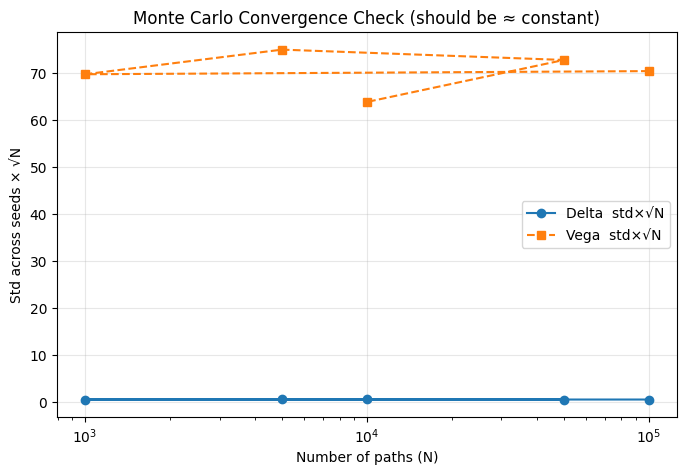

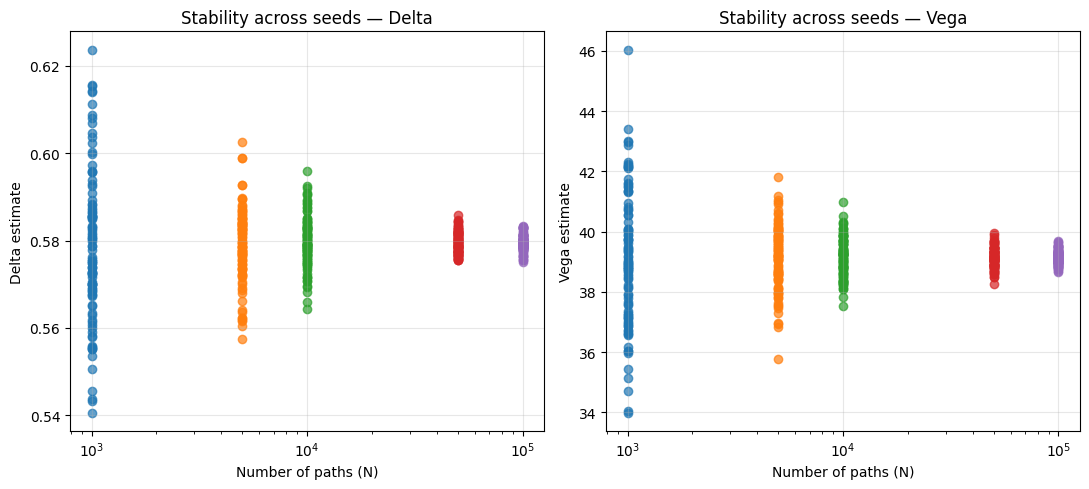

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
from itertools import product

path_grid = [1_000, 5_000, 10_000, 50_000, 100_000]
seed_grid = list(range(100))  

records = []

# ---- Run simulations ----
for n_paths, seed in product(path_grid, seed_grid):
    delta_pw, delta_pw_se = delta_pathwise_call(s0, K, r, q, sigma, T, steps, n_paths, seed)
    vega_pw,  vega_pw_se  = vega_pathwise_call(s0, K, r, q, sigma, T, steps, n_paths, seed)
    records.append((n_paths, seed, delta_pw, delta_pw_se, vega_pw, vega_pw_se))

# ---- Aggregate results ----
df = pl.DataFrame(records, schema=[
    "paths", "seed", "delta", "delta_se", "vega", "vega_se"
], orient="row")

# Accross Seeds for same paths
summary = (
    df.group_by("paths")
      .agg([
          pl.col("delta").mean().alias("mean_delta"),
          pl.col("delta").std().alias("std_delta_across_seeds"),
          pl.col("delta_se").mean().alias("mean_delta_se"),
          pl.col("vega").mean().alias("mean_vega"),
          pl.col("vega").std().alias("std_vega_across_seeds"),
          pl.col("vega_se").mean().alias("mean_vega_se"),
      ])
      .with_columns([
          (pl.col("std_delta_across_seeds") * np.sqrt(pl.col("paths")))
              .alias("delta_std_x_sqrtN"),
          (pl.col("std_vega_across_seeds") * np.sqrt(pl.col("paths")))
              .alias("vega_std_x_sqrtN"),
      ])
)
pl.Config.set_tbl_cols(-1)  # -1 = no column limit
pl.Config.set_tbl_rows(-1)  # -1 = show all rows
pl.Config.set_tbl_width_chars(200)  # wider display

print(summary)
# display(summary.to_pandas())

# ---- Plot convergence: std × √N vs N ----
plt.figure(figsize=(8,5))
plt.plot(summary["paths"], summary["delta_std_x_sqrtN"], 'o-', label="Delta  std×√N")
plt.plot(summary["paths"], summary["vega_std_x_sqrtN"], 's--', label="Vega  std×√N")
plt.xscale("log")
plt.xlabel("Number of paths (N)")
plt.ylabel("Std across seeds × √N")
plt.title("Monte Carlo Convergence Check (should be ≈ constant) - Pathwise Method")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---- Plot stability: estimates across seeds ----
fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=False)

for n_paths in path_grid:
    subset = df.filter(pl.col("paths") == n_paths)
    ax[0].scatter([n_paths]*len(subset["delta"]), subset["delta"], label=f"N={n_paths}", alpha=0.7)
    ax[1].scatter([n_paths]*len(subset["vega"]),  subset["vega"],  label=f"N={n_paths}", alpha=0.7)

for a, name in zip(ax, ["Delta", "Vega"]):
    a.set_xscale("log")
    a.set_xlabel("Number of paths (N)")
    a.set_ylabel(f"{name} estimate")
    a.set_title(f"Stability across seeds — {name} - Pathwise Method")
    a.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

shape: (5, 9)
┌────────┬────────────┬────────────────────────┬───────────────┬───────────┬───────────────────────┬──────────────┬───────────────────┬──────────────────┐
│ paths  ┆ mean_delta ┆ std_delta_across_seeds ┆ mean_delta_se ┆ mean_vega ┆ std_vega_across_seeds ┆ mean_vega_se ┆ delta_std_x_sqrtN ┆ vega_std_x_sqrtN │
│ ---    ┆ ---        ┆ ---                    ┆ ---           ┆ ---       ┆ ---                   ┆ ---          ┆ ---               ┆ ---              │
│ i64    ┆ f64        ┆ f64                    ┆ f64           ┆ f64       ┆ f64                   ┆ f64          ┆ f64               ┆ f64              │
╞════════╪════════════╪════════════════════════╪═══════════════╪═══════════╪═══════════════════════╪══════════════╪═══════════════════╪══════════════════╡
│ 1000   ┆ 0.611183   ┆ 0.586226               ┆ 0.617355      ┆ 42.298728 ┆ 58.456928             ┆ 61.760923    ┆ 18.538084         ┆ 1848.570364      │
│ 100000 ┆ 0.585989   ┆ 0.060708               ┆ 0.06176

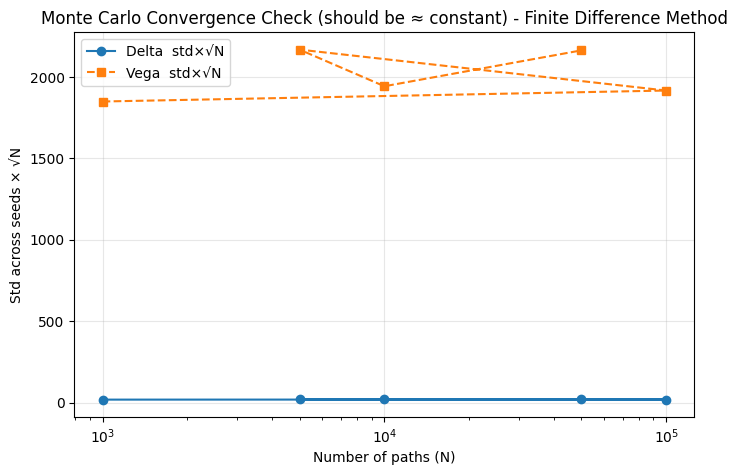

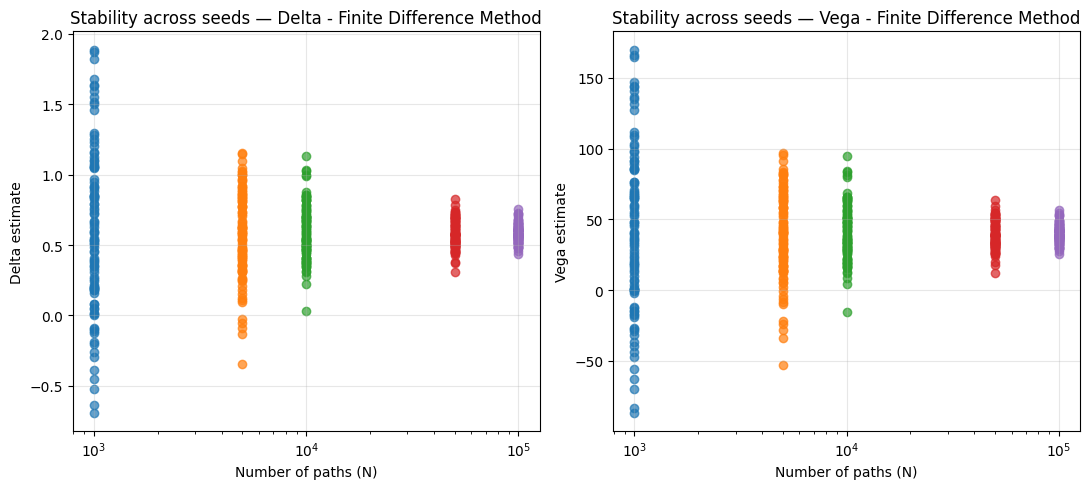

In [20]:
import polars as pl
import matplotlib.pyplot as plt
from itertools import product

path_grid = [1_000, 5_000, 10_000, 50_000, 100_000]
seed_grid = list(range(100))  

records = []

# ---- Run simulations ----
for n_paths, seed in product(path_grid, seed_grid):
    delta_fd, delta_fd_se = delta_bump_call(s0, K, r, q, sigma, T, steps, n_paths, h_S0, seed)
    vega_fd,  vega_fd_se  = vega_bump_call(s0, K, r, q, sigma, T, steps, n_paths, h_sigma, seed)
    records.append((n_paths, seed, delta_fd, delta_fd_se, vega_fd, vega_fd_se))

# ---- Aggregate results ----
df = pl.DataFrame(records, schema=[
    "paths", "seed", "delta", "delta_se", "vega", "vega_se"
], orient="row")

# Accross Seeds for same paths
summary = (
    df.group_by("paths")
      .agg([
          pl.col("delta").mean().alias("mean_delta"),
          pl.col("delta").std().alias("std_delta_across_seeds"),
          pl.col("delta_se").mean().alias("mean_delta_se"),
          pl.col("vega").mean().alias("mean_vega"),
          pl.col("vega").std().alias("std_vega_across_seeds"),
          pl.col("vega_se").mean().alias("mean_vega_se"),
      ])
      .with_columns([
          (pl.col("std_delta_across_seeds") * np.sqrt(pl.col("paths")))
              .alias("delta_std_x_sqrtN"),
          (pl.col("std_vega_across_seeds") * np.sqrt(pl.col("paths")))
              .alias("vega_std_x_sqrtN"),
      ])
)
pl.Config.set_tbl_cols(-1)  # -1 = no column limit
pl.Config.set_tbl_rows(-1)  # -1 = show all rows
pl.Config.set_tbl_width_chars(200)  # wider display

print(summary)
# display(summary.to_pandas())

# ---- Plot convergence: std × √N vs N ----
plt.figure(figsize=(8,5))
plt.plot(summary["paths"], summary["delta_std_x_sqrtN"], 'o-', label="Delta  std×√N")
plt.plot(summary["paths"], summary["vega_std_x_sqrtN"], 's--', label="Vega  std×√N")
plt.xscale("log")
plt.xlabel("Number of paths (N)")
plt.ylabel("Std across seeds × √N")
plt.title("Monte Carlo Convergence Check (should be ≈ constant) - Finite Difference Method")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---- Plot stability: estimates across seeds ----
fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=False)

for n_paths in path_grid:
    subset = df.filter(pl.col("paths") == n_paths)
    ax[0].scatter([n_paths]*len(subset["delta"]), subset["delta"], label=f"N={n_paths}", alpha=0.7)
    ax[1].scatter([n_paths]*len(subset["vega"]),  subset["vega"],  label=f"N={n_paths}", alpha=0.7)

for a, name in zip(ax, ["Delta", "Vega"]):
    a.set_xscale("log")
    a.set_xlabel("Number of paths (N)")
    a.set_ylabel(f"{name} estimate")
    a.set_title(f"Stability across seeds — {name} - Finite Difference Method")
    a.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

shape: (5, 9)
┌────────┬────────────┬────────────────────────┬───────────────┬───────────┬───────────────────────┬──────────────┬───────────────────┬──────────────────┐
│ paths  ┆ mean_delta ┆ std_delta_across_seeds ┆ mean_delta_se ┆ mean_vega ┆ std_vega_across_seeds ┆ mean_vega_se ┆ delta_std_x_sqrtN ┆ vega_std_x_sqrtN │
│ ---    ┆ ---        ┆ ---                    ┆ ---           ┆ ---       ┆ ---                   ┆ ---          ┆ ---               ┆ ---              │
│ i64    ┆ f64        ┆ f64                    ┆ f64           ┆ f64       ┆ f64                   ┆ f64          ┆ f64               ┆ f64              │
╞════════╪════════════╪════════════════════════╪═══════════════╪═══════════╪═══════════════════════╪══════════════╪═══════════════════╪══════════════════╡
│ 1000   ┆ 0.579946   ┆ 0.04116                ┆ 0.044043      ┆ 39.584922 ┆ 7.991278              ┆ 8.257986     ┆ 1.301586          ┆ 252.706402       │
│ 50000  ┆ 0.579958   ┆ 0.006227               ┆ 0.00621

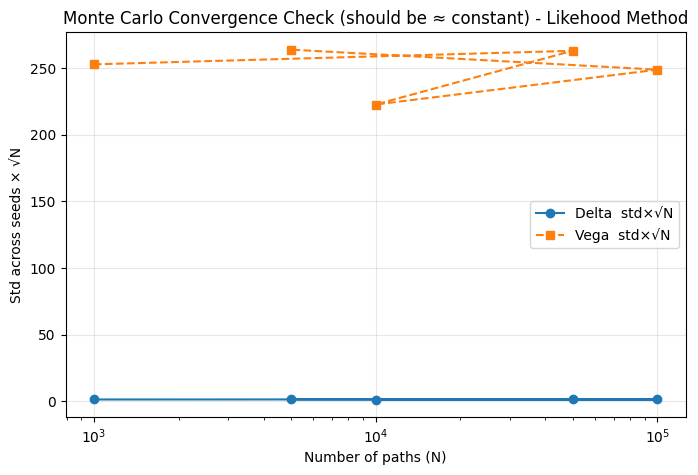

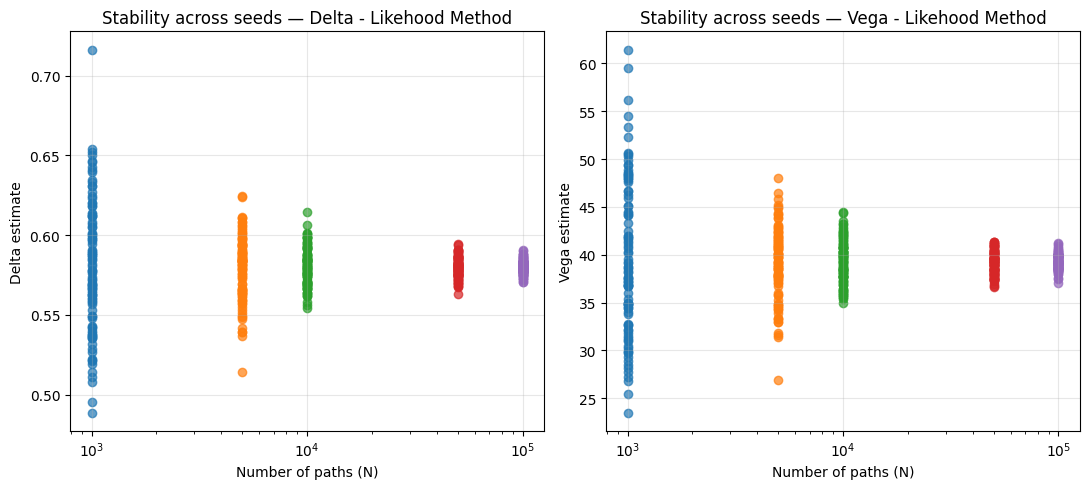

In [21]:
import polars as pl
import matplotlib.pyplot as plt
from itertools import product

path_grid = [1_000, 5_000, 10_000, 50_000, 100_000]
seed_grid = list(range(100))  

records = []

# ---- Run simulations ----
for n_paths, seed in product(path_grid, seed_grid):
    delta_lr, delta_lr_se = delta_lrm_call(s0, K, r, q, sigma, T, steps, n_paths, seed)
    vega_lr,  vega_lr_se  = vega_lrm_call(s0, K, r, q, sigma, T, steps, n_paths, seed)
    records.append(( n_paths, seed, delta_lr, delta_lr_se, vega_lr, vega_lr_se))

# ---- Aggregate results ----
df = pl.DataFrame(records, schema=[
    "paths", "seed", "delta", "delta_se", "vega", "vega_se"
], orient="row")

# Accross Seeds for same paths
summary = (
    df.group_by("paths")
      .agg([
          pl.col("delta").mean().alias("mean_delta"),
          pl.col("delta").std().alias("std_delta_across_seeds"),
          pl.col("delta_se").mean().alias("mean_delta_se"),
          pl.col("vega").mean().alias("mean_vega"),
          pl.col("vega").std().alias("std_vega_across_seeds"),
          pl.col("vega_se").mean().alias("mean_vega_se"),
      ])
      .with_columns([
          (pl.col("std_delta_across_seeds") * np.sqrt(pl.col("paths")))
              .alias("delta_std_x_sqrtN"),
          (pl.col("std_vega_across_seeds") * np.sqrt(pl.col("paths")))
              .alias("vega_std_x_sqrtN"),
      ])
)
pl.Config.set_tbl_cols(-1)  # -1 = no column limit
pl.Config.set_tbl_rows(-1)  # -1 = show all rows
pl.Config.set_tbl_width_chars(200)  # wider display

print(summary)
# display(summary.to_pandas())

# ---- Plot convergence: std × √N vs N ----
plt.figure(figsize=(8,5))
plt.plot(summary["paths"], summary["delta_std_x_sqrtN"], 'o-', label="Delta  std×√N")
plt.plot(summary["paths"], summary["vega_std_x_sqrtN"], 's--', label="Vega  std×√N")
plt.xscale("log")
plt.xlabel("Number of paths (N)")
plt.ylabel("Std across seeds × √N")
plt.title("Monte Carlo Convergence Check (should be ≈ constant) - Likehood Method")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---- Plot stability: estimates across seeds ----
fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=False)

for n_paths in path_grid:
    subset = df.filter(pl.col("paths") == n_paths)
    ax[0].scatter([n_paths]*len(subset["delta"]), subset["delta"], label=f"N={n_paths}", alpha=0.7)
    ax[1].scatter([n_paths]*len(subset["vega"]),  subset["vega"],  label=f"N={n_paths}", alpha=0.7)

for a, name in zip(ax, ["Delta", "Vega"]):
    a.set_xscale("log")
    a.set_xlabel("Number of paths (N)")
    a.set_ylabel(f"{name} estimate")
    a.set_title(f"Stability across seeds — {name} - Likehood Method")
    a.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()